In [11]:
# Initialization of libraries
import torch
import torch.nn
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy.random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as ss
import os

from tqdm import tqdm 
import random
from sklearn.mixture import GMM
device = torch.device('cuda')
%matplotlib inline

In [12]:
# defining parameters for the training
mb_size = 256 # Batch Size
Z_dim = 64  # Length of noise vector
X_dim = 1  # Input Length
y_dim = 3  # Number of classes
h_dim = 10  # Hidden Dimension
lr = 2e-4    # Learning Rate

In [13]:
def one_hot_embedding(labels, num_classes=3):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 


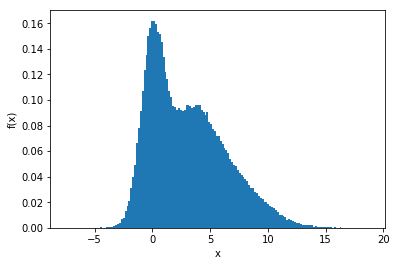

In [14]:
#https://stackoverflow.com/questions/49106806/how-to-do-a-simple-gaussian-mixture-sampling-and-pdf-plotting-with-numpy-scipy

#Number of data points that needs to be sampled
n = 200000
numpy.random.seed(0x5eed)
# Parameters of the mixture components

# Mean and standard deviation of the gaussian
norm_params = np.array([[0, 1],
                        [3, 2],
                        [6, 3]])

# Number of components for the mixture of gaussian(MoG)
n_components = norm_params.shape[0]

# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / 3.0

# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)

# y is the mixture sample
y = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),dtype=np.float64)

plt.hist(y, normed=True, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [15]:
# Normalization of the input data between 0-1
y_copy = y
data = (y - y.min())/(y.max()-y.min())
# Corresponding classes for each data point
g_classes = mixture_idx

In [16]:
# Generator Network
G = torch.nn.Sequential(
    torch.nn.Linear(Z_dim + y_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.PReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

# Initializing discriminator networks

# Discriminator network for classifying real/fake.
D_gan = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)

# Discriminator network for classifying a sample to its corresponding classes.
D_aux = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, y_dim)
)

# Discriminator network for classifying a generator sample to its corresponding classes.
TD_aux = torch.nn.Sequential(
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, h_dim),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Linear(h_dim, y_dim)
)

# Porting the model to GPU.
G = G.cuda()
D_gan = D_gan.cuda()
D_aux = D_aux.cuda()
TD_aux = TD_aux.cuda()

In [17]:
# Init. the optimizer for each network.
G_solver = optim.Adam(G.parameters(), lr,  betas=(0.0, 0.999))
D_solver = optim.Adam((list(D_gan.parameters()) + list(D_aux.parameters())), lr,  betas=(0.0, 0.999))
TD_solver = optim.Adam(TD_aux.parameters(), lr,  betas=(0.0, 0.999))

# Init. the loss function.
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# zero and one labels
ones_label = torch.ones(mb_size,1)
zeros_label = torch.zeros(mb_size,1)
ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

In [18]:
# Reset the gradients to zero
params = [G, D_gan, D_aux,TD_aux]
def reset_grad():
    for net in params:
        net.zero_grad()

In [19]:
data_index = 0

for it in tqdm(range(25000)):
    
    # ###
    if ((data_index + 1)*mb_size>len(data)):
        data_index = 0
    # ###
    for diter in range(10):
        z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
        X = torch.from_numpy(np.array(data[data_index*mb_size : (data_index + 1)*mb_size]))
        X = X.view(mb_size, 1)
        X = X.type(torch.FloatTensor)

        y = torch.from_numpy(np.array(g_classes[data_index*mb_size : (data_index + 1)*mb_size]))


        y_one_hot = one_hot_embedding(y)
        y_one_hot = y_one_hot.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)

        X = X.to(device)
        z = z.to(device)

        y_one_hot = y_one_hot.to(device)
        y = y.to(device)

        # Dicriminator forward-loss-backward-update
        #forward pass
        G_sample = G(torch.cat([z, y_one_hot], 1))

        D_real_gan = D_gan(X)
        D_real_aux = D_aux(X)

        D_fake_gan = D_gan(G_sample)
        D_fake_aux = D_aux(G_sample)

        # Calculate the loss
        D_loss_real = adversarial_loss(D_real_gan, ones_label) + auxiliary_loss(D_real_aux, y) 
        D_loss_fake = adversarial_loss(D_fake_gan, zeros_label) + auxiliary_loss(D_fake_aux, y) 
        
        D_loss = D_loss_real + D_loss_fake

        # Calulate and update gradients of discriminator
        D_loss.backward()
        D_solver.step()

        # reset gradient
        reset_grad()
    
    # Generator forward-loss-backward-update

    G_sample = G(torch.cat([z, y_one_hot], 1))
    
    D_fake_gan = D_gan(G_sample)
    D_fake_aux = D_aux(G_sample) 
    D_real_aux = D_aux(X)
    
    TD_fake_aux = TD_aux(G_sample)
    
    G_loss = adversarial_loss(D_fake_gan, ones_label) + auxiliary_loss(TD_fake_aux, y) + auxiliary_loss(D_real_aux, y) + auxiliary_loss(D_fake_aux, y)

    G_loss.backward()
    G_solver.step()
    TD_solver.step()
    # reset gradient
    reset_grad()

    data_index = data_index + 1
    # Print and plot every now and then
    #if it % 500 == 0:
    #    print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

100%|██████████| 25000/25000 [14:31<00:00, 28.68it/s]


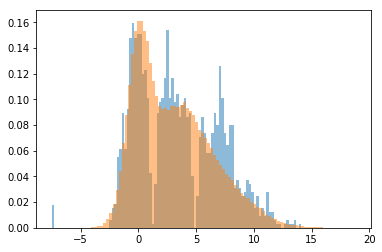

In [20]:
final = np.zeros(1500*mb_size, dtype = float)
for i in range(1500):

    z = torch.FloatTensor(mb_size, Z_dim).uniform_(-1, 1)
    z = z.to(device)

    y = torch.randint(0, 3, (mb_size,)).type(torch.LongTensor)
    y_one_hot = one_hot_embedding(y)
    y_one_hot = y_one_hot.type(torch.FloatTensor)
    y_one_hot = y_one_hot.to(device)
    l = G(torch.cat([z,y_one_hot], 1)).cpu().detach().numpy()
    final[i*mb_size : ((i+ 1)*mb_size -1)] = l[0]

final = y_copy.min() + final*(y_copy.max()-y_copy.min())
fig, ax = plt.subplots( nrows=1, ncols=1 )
p1 = plt.hist(final, 100, normed=True, histtype='stepfilled', alpha=0.5)
p2 = plt.hist(y_copy, 100, normed=True, histtype='stepfilled', alpha=0.5)